In [35]:
import tensorflow as tf
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
assert sys.version_info.major == 3
np.random.seed(1)
from sklearn.linear_model import LinearRegression

# 3 - Linear Regression Revisited

Recall from notebook 1 that we were trying to fit a line to a series of points. To do so we measured a loss function, which tells us how 'good' a fit to the points we have. We minimised this loss function using a process called gradient descent.

We're now going to expand on this example, and introduce solving it with TensorFlow.

### 3.1 - Bias

If you recall from school, you will have seen that the equation of a line is:

$$y = ax + b$$

In this equation $b$ is called the intercept. This is an extremely important term, because by including it, our line no longer has to pass through the origin. Now, we are able to represent any line on the $xy$ plane. This is shown below:

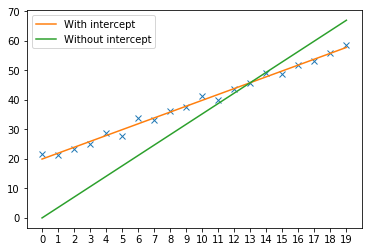

In [36]:
x_vals = np.arange(20).reshape(-1, 1)
y_vals = 2 * x_vals + 20
y_noisy_vals = np.random.normal(y_vals, scale=1.0)


## Don't worry about this code
## it uses a Python library (sklearn)
## which we havent't covered
fit_bias = LinearRegression()
fit_no_bias = LinearRegression(fit_intercept=False)

fit_bias.fit(x_vals, y_noisy_vals)
fit_no_bias.fit(x_vals, y_noisy_vals)

fig_1 = plt.figure()
ax_1 = fig_1.add_subplot(1, 1, 1)
ax_1.plot(x_vals, y_noisy_vals, 'x')
ax_1.set_xticks(x_vals)
bias, = ax_1.plot(x_vals, fit_bias.coef_ * x_vals + fit_bias.intercept_, label='With intercept')
no_bias, = ax_1.plot(x_vals, fit_no_bias.coef_ * x_vals + fit_no_bias.intercept_, label='Without intercept')
plt.legend(handles=[bias, no_bias])
plt.show()

We can see what the intercept term does in this example, it allows the line to 'meet' the data, rather than being constrained to the origin.

In ML it is more common to refer to the intercept as the **bias**. We will redefine the equation in our notation:

$$y = w_0 + w_1 x$$

### 3.2 - Fitting with TensorFlow

We will now fit this model using TensorFlow.

First we create our variables, which are the weights of our regression model, and our placeholders:

In [37]:
tf.reset_default_graph()
w_0 = tf.get_variable('w_0', dtype=tf.float32, initializer=0.0)
w_1 = tf.get_variable('w_1', shape=[], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

x = tf.placeholder(dtype=tf.float32, shape = [None, 1], name='x')
y = tf.placeholder(dtype=tf.float32, shape = [None, 1], name='y')

It is acceptable to initialise the bias term as 0, for reasons we won't go into yet.

You may be wondering what is going on with the x and y placeholders' shapes. It is often the case that we may not know how many training examples we will have prior to feeding in the data. In this instance, we can set the shape to the best of our knowledge and let TF work it out at runtime.

We then define the operation to initialise our variables:

In [38]:
init = tf.global_variables_initializer()

Now we define the function which will make the predictions:

In [39]:
y_pred = w_0 + w_1 * x

And the loss function:

In [40]:
n = x_vals.shape[0]
l2_loss = tf.reduce_sum(tf.pow(y_pred - y, 2))/(2 * n)

Now, in the previous notebook, we defined our gradient descent operation manually, and we calculated the gradient analytically. In TF we define an _optimiser_, which will do this for us:

```optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)```

We can see that we are using a gradient descent optimiser, where we can define the learning rate. It is a class, and we can call the ```minimize``` method of it, by supplying the function we want to minimise.

We will define our optimiser as follows:

In [41]:
optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(l2_loss)

Now we can construct and run our graph:

In [42]:
with tf.Session() as sess:
    sess.run(init)
    
    # We will run the optimiser for 1000 steps
    for step in range(0, 1000):
        sess.run(optimizer, feed_dict={x: x_vals, y: y_noisy_vals})
#         print("w_0: {}".format(sess.run(w_0)))
#         print("w_1: {}".format(sess.run(w_1)))
#         print(sess.run(l2_loss, feed_dict={x: x_vals, y: y_noisy_vals}))
        w_0_tf = sess.run(w_0)
        w_1_tf = sess.run(w_1)
        
print("gradient descent w0: {}".format(w_0_tf))
print("Underlying w0: {}".format(20))
print("gradient descent w1: {}".format(w_1_tf))
print("Underlying w1: {}".format(2))

gradient descent w0: 18.595834732055664
Underlying w0: 20
gradient descent w1: 2.0957436561584473
Underlying w1: 2


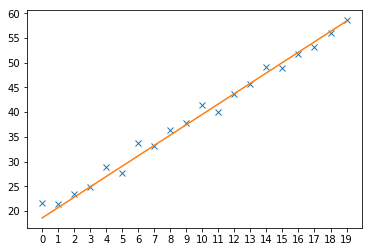

In [43]:
fig = plt.figure()
ax_1 = fig.add_subplot(1, 1, 1)
ax_1.plot(x_vals, y_noisy_vals, 'x')
ax_1.set_xticks(x_vals)
ax_1.plot(x_vals, w_1_tf * x_vals + w_0_tf, label='With intercept')
plt.show()

Great! That looks like a pretty good fit to the data.

### 3.3 - Features

If we wanted to fit a quadratic function of the form:

$$y = ax + bx^2 + c$$

Or, in our notation:

$$y = w_0 + w_1 x + w_2x^2$$

We can still use linear regression. 

Now, you may be confused as to our we are using _linear_ regression for a function which is non-linear. This confused me too, initially, but we must remember that although the function is non-linear in $x$ it is linear in the parameters $w$, which is what we are fitting.

We can use exactly the same principles as before, as shown below:

gradient descent w0: 10.7803373336792
Underlying w0: 20
gradient descent w1: -1.0643821954727173
Underlying w1: 2
gradient descent w2: 0.9166293144226074
Underlying w2: 3


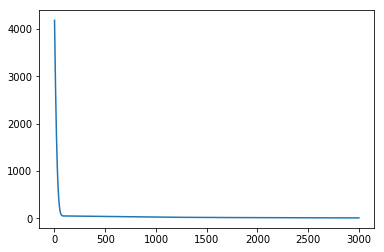

In [44]:
x_vals = np.arange(20).reshape(-1, 1)
y_vals = 20 - 3 * x_vals + 1 * x_vals ** 2
y_noisy_vals = np.random.normal(y_vals, scale=3.0)

tf.reset_default_graph()
w_0 = tf.get_variable('w_0', dtype=tf.float32, initializer=0.0)
w_1 = tf.get_variable('w_1', shape=[], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
w_2 = tf.get_variable('w_2', shape=[], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

x = tf.placeholder(dtype=tf.float32, shape = [None, 1], name='x')
y = tf.placeholder(dtype=tf.float32, shape = [None, 1], name='y')

y_pred = w_0 + w_1 * x + w_2 * x ** 2

n = x_vals.shape[0]
l2_loss = tf.reduce_sum(tf.pow(y_pred - y, 2))/(2 * n)

# The learning rate is quite small for this example
# Try it with a larger value e.g. 1e-3 and see what happens
optimizer = tf.train.AdamOptimizer(1e-2).minimize(l2_loss)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    loss_vals = []
    num_steps = 3000
    # We will run the optimiser for 100 steps
    for step in range(0, num_steps):
        sess.run(optimizer, feed_dict={x: x_vals, y: y_noisy_vals})
        loss_vals.append(sess.run(l2_loss, feed_dict={x: x_vals, y: y_noisy_vals}))
        w_0_tf = sess.run(w_0)
        w_1_tf = sess.run(w_1)
        w_2_tf = sess.run(w_2)
        
        
print("gradient descent w0: {}".format(w_0_tf))
print("Underlying w0: {}".format(20))
print("gradient descent w1: {}".format(w_1_tf))
print("Underlying w1: {}".format(2))
print("gradient descent w2: {}".format(w_2_tf))
print("Underlying w2: {}".format(3))

# It's often a good idea to visualise the loss
fig = plt.figure()
ax_1 = fig.add_subplot(1, 1, 1)
ax_1.plot(range(1, num_steps), loss_vals[1:])
plt.show()

Hmm, the weights look quite far away from the underlying ones, but the loss does appear to be well behaved. Let's have a look:

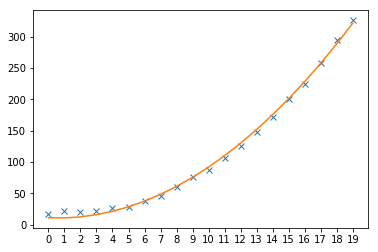

In [45]:
fig = plt.figure()
ax_1 = fig.add_subplot(1, 1, 1)
ax_1.plot(x_vals, y_noisy_vals, 'x')
ax_1.set_xticks(x_vals)
ax_1.plot(x_vals, w_0_tf + w_1_tf * x_vals + w_2_tf * x_vals ** 2, label='With intercept')
plt.show()

We actually have a fairly good fit to the data, although it appeared our weights were quite far away. This is one of the issues with polynomials, in that they are very sensitive to small changes in the parameters.

What we have done here is modelled a regression problem with a new value: $x^2$. So far, we have just been calling these the x's, but now we are going to refer to them as **features**. If we recall our equation from before:

$$y = w_0 + w_1 x + w_2x^2$$

We can see that it is also possible to write it as:

$$y = w_0x^0 + w_1 x^1 + w_2x^2$$

Not only that, but we can go further. Suppose we define a weight vector $\mathbf{w} = [w_0\ w_1\ w_2]^T$, and a feature vector $\mathbf{x} = [x^0\ x^1\ x^2]^T$, then we can re-write the equation as:

$$y = \mathbf{w}^T \mathbf{x}$$

And note that our $\mathbf{x}$ vector will always have an initial value of 1, to represent the bias term, so it will take the form: $\mathbf{x} = [1\ x^1\ x^2]^T$

We've been slightly sneaky so far in the way in which we have presented our x and y values, but we did so for simplicity. Now we are going to slightly redefine those terms.  

For our functions we have a direct mapping of $x \rightarrow y$, that is, we can supply an $x$ value, and obtain a $y$ value from our equation. These can be considered as data pairs: $\{x^{(n)}, y^{(n)}\}_{n=1}^{N}$, where we have $N$ examples. Note that the superscript term is _not_ a power term, but rather the i-th example. ML is notorious for poorly defined notation, so we will try and keep ours as clear as possible.

In our quadratic equation from before, this means that each feature vector is now defined as: 

$$\mathbf{x}^{(n)} = [1\ x^{(n)}\ x^{(n)^2}]^T$$

We can store these in a **feature matrix**, $X$, such that:

$$X = \begin{bmatrix}\mathbf{x}^{(1)^T}\\
\mathbf{x}^{(2)^T}\\
\dots\\
\mathbf{x}^{(N)^T}\\
\end{bmatrix}$$

Now we can rewrite our function entirely in matrix notation:

$$\mathbf{y}_{pred} = X\mathbf{w}$$

Understanding the linear algebra representation of the problem makes the solutions far more computationally efficient. Fortunately TF overloads the numerical operators for us, so we have been using the linear algebra, or _vectorised_ implementatations without realising it.

Ok. All of this is all well and good, but you might be thinking: "I still don't really _get_ features. Why are we squaring terms, what's going on?". 

We have covered a lot of material, and introduced some notation, so it's worth reviewing that before continuing and making sure you really understand it.

---

### 3.5 - Overfitting

Features are a measure of the representational power of our function. That is, how complex a function we are able to create. In ML, we are often faced with balancing a good fit to the data, versus predictive power. How we handle the features is key to this balancing act. Let us demonstrate with an example. 

Suppose we are given the following data:

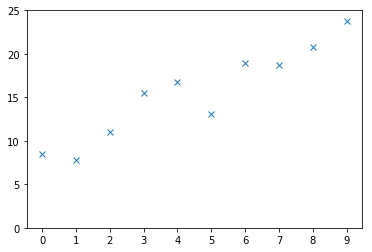

In [115]:
import raw_data

y_vals = raw_data.example_data_10
x_orig = np.arange(y_vals.shape[0]).reshape(-1, 1)
fig = plt.figure()
ax_1 = fig.add_subplot(1, 1, 1)
ax_1.plot(x_orig, y_vals, 'x')
ax_1.set_xticks(x_orig)
ax_1.set_ylim([0, 25])
plt.show()

It's not clear what the underlying function is, but let's try with a straight line:

In [132]:
# We'll add the 1 term to each feature vector:
x_with_bias = np.hstack((np.ones((x_orig.shape[0], 1)), x_orig))
print(x_with_bias)

[[ 1.  0.]
 [ 1.  1.]
 [ 1.  2.]
 [ 1.  3.]
 [ 1.  4.]
 [ 1.  5.]
 [ 1.  6.]
 [ 1.  7.]
 [ 1.  8.]
 [ 1.  9.]]


In [133]:
l2_loss = lambda y_pred, y, num_train: np.sum((y_pred - y) ** 2)/(2 * num_train)

In [227]:
line = LinearRegression(fit_intercept=False)
line.fit(x_vals, y_vals)

straight_line_coeffs = line.coef_.T
y_predicted_1 = x_vals.dot(straight_line_coeffs)

#y_predicted = coeffs.
num_train = x_vals.shape[0]

straight_line_loss = l2_loss(y_predicted_1, y_vals, num_train)
print("Loss using a straight line: {}".format(straight_line_loss))

Loss using a straight line: 1.3928710271180242


Ok, not bad. Can we do better? Let's try adding in a new feature, a squared term.

In [142]:
x_with_squared = np.hstack((x_with_bias, x_orig**2))
print(x_with_squared)

[[  1.   0.   0.]
 [  1.   1.   1.]
 [  1.   2.   4.]
 [  1.   3.   9.]
 [  1.   4.  16.]
 [  1.   5.  25.]
 [  1.   6.  36.]
 [  1.   7.  49.]
 [  1.   8.  64.]
 [  1.   9.  81.]]


And we'll fit this quadratic function to the data:

In [143]:
line = LinearRegression(fit_intercept=False)
line.fit(x_with_squared, y_vals)

coeffs = line.coef_.T
y_predicted_2 = x_with_squared.dot(coeffs)

#y_predicted = coeffs.
num_train = x_with_squared.shape[0]

print("Loss using a quadratic function: {}".format(l2_loss(y_predicted, y_vals, num_train)))

Loss using a quadratic function: 1.3927162009918461


Ok, great! Our loss is now smaller than with just using the straight line. What if we went to an even higher power? What if we went all the way up to a ninth-order polynomial?

In [181]:
x_matrix = x_with_bias
l2_loss_polynomial = [straight_line_loss]
best_coeffs = None
best_loss = float('inf')
for power in range(2, 10):
    
    # Create the feature matrix
    # stacking the extra powers 
    x_matrix = np.hstack((x_matrix, x_orig**power))
    
    line = LinearRegression(fit_intercept=False)
    line.fit(x_matrix, y_vals)

    coeffs = line.coef_.T
    y_predicted = x_matrix.dot(coeffs)

    #y_predicted = coeffs.
    num_train = x_vals.shape[0]

    loss = l2_loss(y_predicted, y_vals, num_train)
    l2_loss_polynomial.append(loss)
    
    print(loss)
    print(coeffs.shape)
    if loss < best_loss:
        best_loss = loss
        best_coeffs = coeffs

1.39271620099
(3, 1)
1.29751111624
(4, 1)
1.16124145873
(5, 1)
0.873975807616
(6, 1)
0.705841827952
(7, 1)
0.593841128791
(8, 1)
0.340075993238
(9, 1)
1.59239480505e-12
(10, 1)


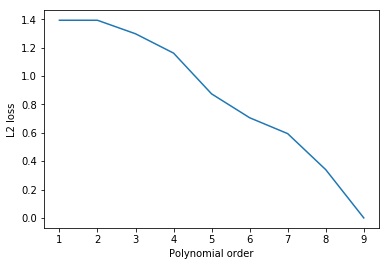

In [184]:
fig = plt.figure()
powers = range(1, 10)
ax_1 = fig.add_subplot(1, 1, 1)
ax_1.plot(powers, l2_loss_polynomial)
ax_1.set_xticks(powers)
ax_1.set_xlabel('Polynomial order')
ax_1.set_ylabel('L2 loss')
plt.show()

Brilliant! We now have a function which obtains near zero loss on the data. Let's visualise what such a beautiful function looks like. 

First, we will generate the x-value points to evaluate our function. We create a vector of 100 values from 0 to 10, and then we create additional polynomial features, so we end up with a matrix of values of shape $100 \times 11$.

In [188]:
x_data = np.linspace(0, 10, 100).reshape(-1, 1)
X = np.hstack((np.ones((100, 1)), x_data))
for i in range(2, 10):
    X = np.hstack((X, x_data ** i))
assert X.shape == (100, 10)

Now we will evaluate the function at these points and plot it, with our original data overlaid:

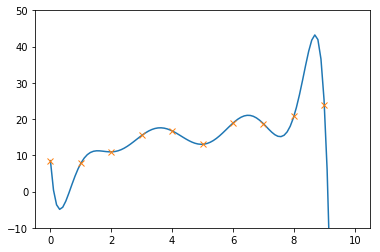

In [198]:
f = X.dot(best_coeffs)
fig = plt.figure()
ax_1 = fig.add_subplot(1, 1, 1)
ax_1.plot(x_data, f)
ax_1.plot(x_orig, y_vals, 'x')

ax_1.set_ylim([-10, 50])
plt.show()

Hmm, that function _does_ fit all the points exactly, but it looks awfully wiggly. Does it look like it would be able to accurately predict new data? Let's find out.

In [223]:
test_x_data = raw_data.x_test.reshape(-1, 1)
test_y_data = raw_data.prediction_data_10.reshape(-1, 1)

x_data = np.linspace(0, 12, 100).reshape(-1, 1)

X = np.hstack((np.ones((x_data.shape[0], 1)), x_data))
for i in range(2, 10):
    X = np.hstack((X, x_data ** i))
assert X.shape == (x_data.shape[0], 10)

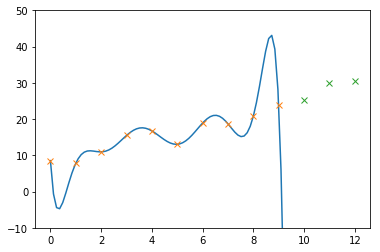

In [225]:
f = X.dot(best_coeffs)
fig = plt.figure()
ax_1 = fig.add_subplot(1, 1, 1)
ax_1.plot(x_data, f)
ax_1.plot(x_orig, y_vals, 'x')
ax_1.plot(test_x_data, test_y_data, 'x')

ax_1.set_ylim([-10, 50])
plt.show()

Uhh... Let's try rescaling the y-axis:

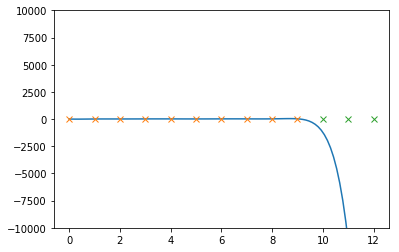

In [226]:
f = X.dot(best_coeffs)
fig = plt.figure()
ax_1 = fig.add_subplot(1, 1, 1)
ax_1.plot(x_data, f)
ax_1.plot(x_orig, y_vals, 'x')
ax_1.plot(test_x_data, test_y_data, 'x')

ax_1.set_ylim([-10000, 10000])
plt.show()

Wow, that's pretty poor. If we were trying to predict those green values, we would be miles away. In contrast, here is the fit of the straight line:

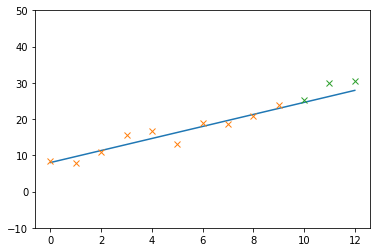

In [237]:
x_data = np.linspace(0, 12, 100).reshape(-1, 1)
X = np.hstack((np.ones((x_data.shape[0], 1)), x_data))

f = X.dot(straight_line_coeffs)
fig = plt.figure()
ax_1 = fig.add_subplot(1, 1, 1)
ax_1.plot(x_data, f)
ax_1.plot(x_orig, y_vals, 'x')
ax_1.plot(test_x_data, test_y_data, 'x')

ax_1.set_ylim([-10, 50])
plt.show()

That looks like a much better prediction, even though we had the highest loss with this function. What happened?

The answer lies in the construction of polynomials. They are nested functions in which a higher-order polynomial can exactly represent a lower-order one simply by setting some coefficients equal to 0.

For example, given a polynomial of order $n$:

$$y = w_0 + w_1x^1 + w_2x^2 + \dots + w_{n-1}x^{n-1} + w_nx^n$$

then we can exactly represent a polynomial of order $n-1$ with:

$$y = w_0 + w_1x^1 + w_2x^2 + \dots + w_{n-1}x^{n-1} + 0x^n$$

That is, $w_n = 0$. What this means is that if we have some loss from a polynomial function, then a higher-order polynomial function will always have a smaller loss, until we reach zero loss.

This means that, given enough polynomial order, we can fit a function that will pass through all the training points, but will not be generalisable at test time. This poses a problem and is referred to **overfitting**.

### 3.6 - Regularisation

One strategy to stop overfitting is to use **regularisation**. These are a collection of techniques designed to reduce the model's susceptibility to overfitting, and allow it to generalise to unseen data. We will focus on one technique: l2 regularisation, also known as ridge regression or Tikhonov regression.

Recall that our L2 loss function was defined as:

$$\mathcal{L}_2 = \frac{1}{2n}\sum_{i=0}^{n}(\hat{y}_i - y_i)^2$$

In ridge regression, we add on an additional term:

$$\mathcal{L}_2 = \frac{1}{2n}\sum_{i=0}^{n}(\hat{y}_i - y_i)^2 + \lambda \sum_{d=1}^{D}w_{d}^{2}$$

Since we are now summing over the squared weights, and we are trying to find the minimum of this overall function, it will force the weights to be small. This prevents the large swings as seen in the previous example.

### 3.4 - Into the second dimension

